# CONTINUAL MULTI-TASK GAUSSIAN PROCESSES
## Example 4.1
The streaming data experiment consists of $t = 10$ batches of data that are observed in a sequential manner.
In this case, we consider that each batch has approximately a similar size, so the scenario is not irregular w.r.t. the
number of samples per batch or their input domain. We setup the initial number of inducing points to be $M = 3$, that
will also be increased following the rule $M(t) = 3t$. The rule can be modified depending on the problem considered, as
we will see later on additional experiments. We consider a synthetic dataset of $N = 2000$ samples where the $30\%$ of
them are used for testing.

In [1]:
%matplotlib inline
import warnings
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.use('TkAgg')

import numpy as np
from sklearn.model_selection import train_test_split
from continualgp.het_likelihood import HetLikelihood
from continualgp.continualgp import ContinualGP
from continualgp import util
from continualgp.util import vem_algorithm as onlineVEM
from hetmogp.svmogp import SVMOGP
from hetmogp.util import vem_algorithm as VEM

from likelihoods.gaussian import Gaussian
from continualgp.het_likelihood import HetLikelihood

N = 2000 # number of samples
M = 3  # number of inducing points
Q = 1  # number of latent function
T = 2 # number of streaming batches
max_X = 0.4 # max of X range
VEM_its = 2
max_iter = 100

# Likelihood Definition
likelihoods_list = [Gaussian(sigma=1.5)]
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()
D = likelihood.num_output_functions(Y_metadata)

X = np.sort(max_X*np.random.rand(N))[:, None]

In [2]:
# True F function
def true_f(X_input):
    f = np.empty((X_input.shape[0], 1))
    f[:,0,None] = 4.5 * np.cos(2 * np.pi * X_input + 1.5*np.pi) - \
                3 * np.sin(4.3 * np.pi * X_input + 0.3 * np.pi) + \
                5 * np.cos(7 * np.pi * X_input + 2.4 * np.pi)
    return [f]

In [3]:
f_train = true_f(X)

# Generation of training data Y (sampling from the likelihood dist.)
Y = likelihood.samples(F=f_train, Y_metadata=Y_metadata)[0]

true_W_list = [np.array(([[1.0]]))]

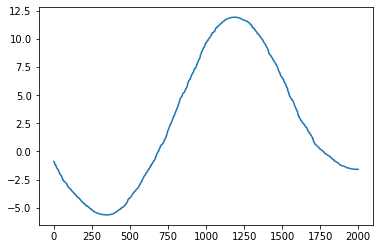

In [4]:
# visualise f_train
plt.plot(f_train[0])

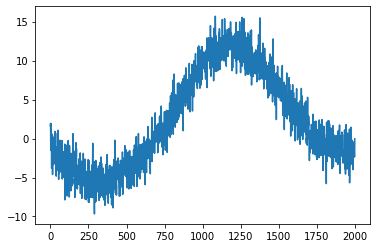

In [5]:
plt.plot(Y)

In [6]:
# Streaming data generator:
def data_streaming(Y_output, X_input, T_sections):
    streaming_Y = []
    streaming_X = []
    N = Y_output.shape[0]
    slice = np.floor(N/T_sections)
    for t in range(T_sections):
        streaming_X.append(X_input[np.r_[int(t*slice):int((t+1)*slice)],:])
        streaming_Y.append(Y_output[np.r_[int(t*slice):int((t+1)*slice)], :])
    return streaming_Y, streaming_X

In [7]:
# Streaming simulation data
stream_Y, stream_X = data_streaming(Y, X, T)

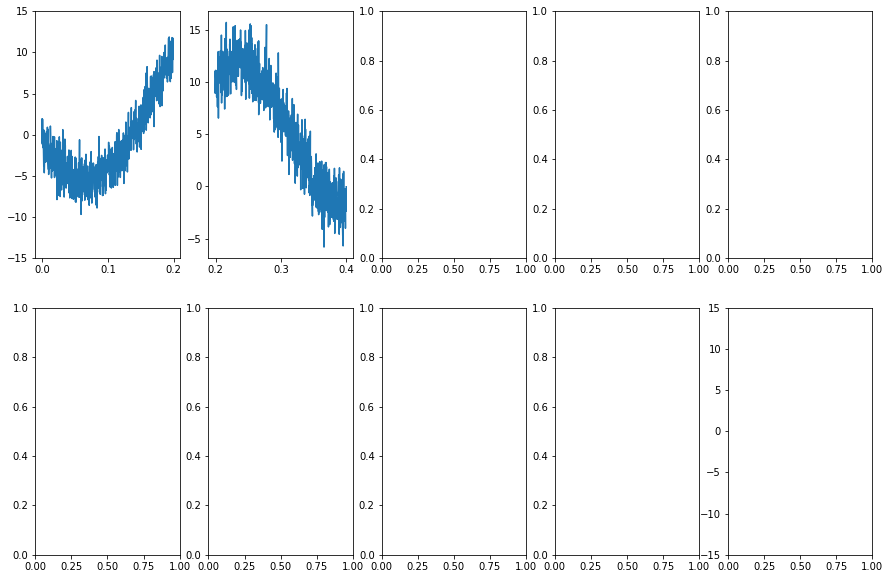

In [8]:
plt.subplots(2,5, figsize=(15,10))
for i in range(len(stream_X)):
    plt.ylim(-15,15)
    plt.subplot(2,5,i+1)
    plt.plot(stream_X[i], stream_Y[i])

In [9]:
# Train/test splitting
stream_Y_train = []
stream_Y_test = []
stream_X_train = []
stream_X_test = []
for t_list in range(T):
    x_train, x_test, y_train, y_test = train_test_split(stream_X[t_list], stream_Y[t_list], test_size = 0.33, random_state = 42)
    stream_Y_train.append(y_train)
    stream_Y_test.append(y_test)
    stream_X_train.append(x_train)
    stream_X_test.append(x_test)

model_list = []
Z_list = []
q_mean_list = []

[Stream 1] ---------------------------------


 C:\Users\ac1dmrx\Anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:divide by zero encountered in log


iteration (1) VE step, ELBO=[-2009.47587482]
iteration (1) VM step, ELBO=[-1936.80747635]
iteration (2) VE step, ELBO=[-1910.94486504]
iteration (2) VM step, ELBO=[-1895.2733109]
[Stream 2] ---------------------------------
[[4.11896261]] [[4.11896261]] [[2.84991716]]
updates were off, setting updates on again
[[4.11896261]] [[4.11896261]] [[1319.44587127]]
[[4.11896261]] [[4.11896261]] [[1319.44587127]]
[[5.1770129]] [[5.1770129]] [[1160.04617033]]
[[14.15965764]] [[14.15965764]] [[665.01629424]]
[[59.24830239]] [[59.24830239]] [[146.09563465]]
[[53.33380723]] [[53.33380723]] [[84.13998097]]
[[55.47338971]] [[55.47338971]] [[39.86752509]]
[[44.76825585]] [[44.76825585]] [[21.02318121]]
[[44.77208957]] [[44.77208957]] [[19.29319009]]
[[45.68773319]] [[45.68773319]] [[18.37544858]]
[[45.00128595]] [[45.00128595]] [[16.48317057]]
[[45.22833183]] [[45.22833183]] [[16.49190256]]
[[45.38583431]] [[45.38583431]] [[16.655899]]
[[45.3309685]] [[45.3309685]] [[16.6734711]]
[[45.32350738]] [[45.

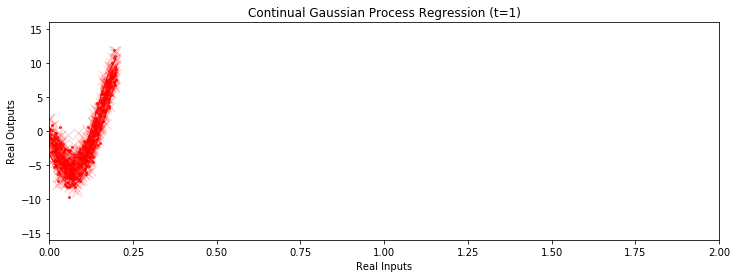

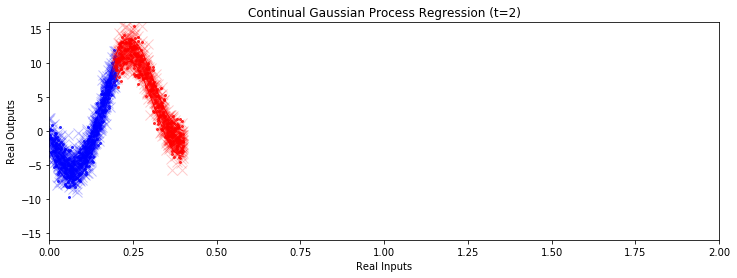

IndexError: list index out of range

In [50]:
# NLPD Test Metrics
iterations = 1
n_samples = 1000
NLPD_results = np.zeros((T,T,iterations))
for t_it in range(iterations):

    # First batch - t=1 -------------------------------
    # Kernels
    ls_q = np.array(([.05] * Q))
    var_q = np.array(([.5] * Q))
    kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=1)

    # Inducing points
    Z = np.linspace(0, np.max(stream_X[0]), M) + 0.005*np.random.randn()
    Z = Z[:, np.newaxis]

    print("[Stream 1] ---------------------------------")
    hetmogp_model = SVMOGP(X=[stream_X[0]], Y=[stream_Y[0]], Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata, W_list=true_W_list)
    Identity = np.eye(Q)

    hetmogp_model = VEM(hetmogp_model, stochastic=False, vem_iters=VEM_its, optZ=False, verbose=False, verbose_plot=False, non_chained=False)
    last_model = hetmogp_model
    model_list.append(last_model)
    Z_list.append(Z)
    q_mean_list.append(hetmogp_model.q_u_means)

    prev_var = hetmogp_model.kern.variance.copy() + 0.0
    prev_ls = hetmogp_model.kern.lengthscale.copy() + 0.0

    prev_marginal = - np.infty
    # Continual training - t=2:T ----------------------
    for t in range(1,T):
        marginal = 1.0
        while marginal > 0.0 or marginal < 2*prev_marginal:
            # KERNELS
            ls_q = np.array(([.01] * Q))
            var_q = np.array(([0.5] * Q))
            prev_ls_q = np.array(([prev_ls] * Q))
            prev_var_q = np.array(([prev_var] * Q))
            kern_list = util.latent_functions_prior(Q, lenghtscale=prev_ls_q, variance=prev_var_q, input_dim=1)
            kern_list_old = util.latent_functions_prior(Q, lenghtscale=prev_ls_q, variance=prev_var_q, input_dim=1)

            # # INDUCING POINTS
            Z = np.linspace(0, np.max(stream_X[t]), (t+1)*M) + 0.005*np.random.randn()
            Z = Z[:, np.newaxis]

            print("[Stream "+str(t+1)+"] ---------------------------------")
            # Model Construction + hyperparameter setup
            online_model = ContinualGP(X=[stream_X[t]], Y=[stream_Y[t]], Z=Z, kern_list=kern_list, kern_list_old=kern_list_old, likelihood=likelihood, Y_metadata=Y_metadata, W_list=true_W_list)
            util.hyperparams_new_to_old(online_model, last_model)
            online_model.phi_means, online_model.phi_chols = util.variational_new_to_old_offline(last_model.q_u_means, last_model.q_u_chols)

            online_model = onlineVEM(online_model, vem_iters=VEM_its, optZ=False, verbose=False, verbose_plot=False, non_chained=False, maxIter_perVEM=max_iter)
            marginal = online_model.log_likelihood().flatten()

        last_model = online_model
        prev_marginal = online_model.log_likelihood().flatten()
        prev_var = online_model.kern.variance.copy() + 0.0
        prev_ls = online_model.kern.lengthscale.copy() + 0.0
        model_list.append(last_model)
        Z_list.append(Z)
        q_mean_list.append(online_model.q_u_means)

    # Latex Plots
    util.plot_streaming_latex(model_list, stream_X_train, stream_X_test, stream_Y_train, stream_Y_test, Z_list, q_mean_list, save=False)

    for t_step in range(T):
        if t_step > 0:
            for t_past in range(t_step+1):
                m_pred, v_pred = model_list[t_step].predictive_new(stream_X_test[t_past], output_function_ind=0)
                nlogpred = - Gaussian(sigma=1.5).log_predictive(stream_Y_test[t_past], m_pred, v_pred, n_samples)
                print('Negative Log-Predictive / model t=' +str(t_step+1) + '/ batch t='+str(t_past+1)+'): ' + str(nlogpred))
                NLPD_results[t_step,t_past,t_it] = nlogpred

        else:
            m_pred, v_pred = model_list[t_step].predictive_new(stream_X_test[t_step], output_function_ind=0)
            nlogpred = - Gaussian(sigma=1.5).log_predictive(stream_Y_test[t_step], m_pred, v_pred, n_samples)
            print('Negative Log-Predictive / model t=' + str(t_step+1) + '/ batch t=' + str(t_step+1) + '): ' + str(nlogpred))
            NLPD_results[t_step, t_step, t_it] = nlogpred

        print('-------------------------------------------------------------------------')


In [53]:
%pycat continualgp/util.py

## Breaking down the algorithm

1) Construct RBF prior for the latent function (where Q is the no. of latent functions) using set lengthscale and variance. Initialise M inducing points.
```
# NLPD Test Metrics
iterations = 1
n_samples = 1000
NLPD_results = np.zeros((T,T,iterations))
for t_it in range(iterations):

    # First batch - t=1 -------------------------------
    # Kernels
    ls_q = np.array(([.05] * Q))
    var_q = np.array(([.5] * Q))
    kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=1)

    # Inducing points
    Z = np.linspace(0, np.max(stream_X[0]), M) + 0.005*np.random.randn()
    Z = Z[:, np.newaxis]
```

In [54]:
def latent_functions_prior(Q, lenghtscale=None, variance=None, input_dim=None, kname=None):
    if lenghtscale is None:
        lenghtscale = np.random.rand(Q)
    else:
        lenghtscale = lenghtscale

    if variance is None:
        variance = np.random.rand(Q)
    else:
        variance = variance

    if kname is None:
        kname = 'rbf'
    else:
        kname = kname

    kern_list = []
    for q in range(Q):
        if kname=='rbf':
            kern_q = kern.RBF(input_dim=input_dim, lengthscale=lenghtscale[q], variance=variance[q], name='rbf')
        else:
            kern_q = kern.Matern32(input_dim=input_dim, lengthscale=lenghtscale[q], variance=variance[q], name='matern')

        kern_q.name = 'kern_q'+str(q)
        kern_list.append(kern_q)
    return kern_list

```
hetmogp_model = SVMOGP(X=[stream_X[0]], Y=[stream_Y[0]], Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata, W_list=true_W_list)
Identity = np.eye(Q)
```


In [62]:
class SVMOGP(GPy.core.SparseGP):
    def __init__(self, X, Y, Z, kern_list, likelihood, Y_metadata, name='SVMOGP', batch_size=None, W_list=None):

        self.batch_size = batch_size
        self.kern_list = kern_list
        self.likelihood = likelihood
        self.Y_metadata = Y_metadata

        self.num_inducing = Z.shape[0]  # M
        self.num_latent_funcs = len(kern_list) # Q
        self.num_output_funcs = likelihood.num_output_functions(self.Y_metadata)
        if W_list is None:
            self.W_list, self.kappa_list = util.random_W_kappas(self.num_latent_funcs, self.num_output_funcs, rank=1)
        else:
            self.W_list = W_list
            _, self.kappa_list = util.random_W_kappas(self.num_latent_funcs, self.num_output_funcs, rank=1)

        self.Xmulti = X
        self.Ymulti = Y

        # Batch the data
        self.Xmulti_all, self.Ymulti_all = X, Y
        if batch_size is None:
            self.stochastic = False
            Xmulti_batch, Ymulti_batch = X, Y
        else:
            # Makes a climin slicer to make drawing minibatches much quicker
            self.stochastic = True
            self.slicer_list = []
            [self.slicer_list.append(draw_mini_slices(Xmulti_task.shape[0], self.batch_size)) for Xmulti_task in self.Xmulti]
            Xmulti_batch, Ymulti_batch = self.new_batch()
            self.Xmulti, self.Ymulti = Xmulti_batch, Ymulti_batch

        # Initialize inducing points Z
        #Z = kmm_init(self.X_all, self.num_inducing)
        self.Xdim = Z.shape[1]
        Z = np.tile(Z,(1,self.num_latent_funcs))

        inference_method = SVMOGPInf()

        super(SVMOGP, self).__init__(X=Xmulti_batch[0][1:10], Y=Ymulti_batch[0][1:10], Z=Z, kernel=kern_list[0], likelihood=likelihood,
                                     mean_function=None, X_variance=None, inference_method=inference_method,
                                     Y_metadata=Y_metadata, name=name, normalizer=False)

        self.unlink_parameter(self.kern)  # Unlink SparseGP default param kernel

        _, self.B_list = util.LCM(input_dim=self.Xdim, output_dim=self.num_output_funcs, rank=1, kernels_list=self.kern_list,
                                  W_list=self.W_list, kappa_list=self.kappa_list)

        # Set-up optimization parameters: [Z, m_u, L_u]
        self.q_u_means = Param('m_u', 2.5*np.random.randn(self.num_inducing, self.num_latent_funcs) +
                               0*np.tile(np.random.randn(1,self.num_latent_funcs),(self.num_inducing,1)))
        chols = choleskies.triang_to_flat(np.tile(np.eye(self.num_inducing)[None,:,:], (self.num_latent_funcs,1,1)))
        self.q_u_chols = Param('L_u', chols)

        self.link_parameter(self.Z, index=0)
        self.link_parameter(self.q_u_means)
        self.link_parameters(self.q_u_chols)
        [self.link_parameter(kern_q) for kern_q in kern_list]  # link all kernels
        [self.link_parameter(B_q) for B_q in self.B_list]

        self.vem_step = True # [True=VE-step, False=VM-step]
        self.ve_count = 0
        self.elbo = np.zeros((1,1))

NameError: name 'GPy' is not defined

In [12]:
def conditional_prior(Z, Zold, kern_list_old, phi_means, phi_chols):
    M, Dz = Z.shape
    Mold, _ = Zold.shape
    Q = len(kern_list_old)

    # Algebra for q(u):
    #phi_m = phi_means.copy()
    phi_L = tf.linalg.cholesky(phi_chols)
    phi_S = np.empty((Q, Mold, Mold))
    [np.dot(phi_L[q, :, :], tf.transpose(phi_L[q, :, :]), phi_S[q, :, :]) for q in range(Q)]

    Mu = np.empty((Q, M, 1))
    Kuu = np.empty((Q, M, M))
    Luu = np.empty((Q, M, M))
    Kuui = np.empty((Q, M, M))

    Kuu_old, Luu_old, Kuui_old = latent_funs_cov(Zold, kern_list_old)
    Kuu_new, _, _ = latent_funs_cov(Z, kern_list_old)
    Kuu_cond = latent_funs_conditional(Z, Zold, kern_list_old)

    for q, kern in enumerate(kern_list_old):
        R, _ = linalg.dpotrs(np.asfortranarray(Luu_old[q, :, :]), Kuu_cond[q, :, :].T)
        Auu = R.T # Kuu_cond * Kuui
        Mu[q, :] = np.dot(Auu, phi_means[:, q, None])
        Kuu[q, :, :] = Kuu_new[q, :, :] + np.dot(np.dot(R.T, phi_S[q, :, :]), R) - np.dot(Kuu_cond[q, :, :], R)
        Luu[q, :, :] = linalg.jitchol(Kuu[q, :, :])
        Kuui[q, :, :], _ = linalg.dpotri(np.asfortranarray(Luu[q, :, :]))
    return Mu, Kuu, Luu, Kuui

In [13]:
import numpy as np
import gpflow 
from GPy.util import choleskies
from GPy.util import linalg
import tensorflow as tf
Zold = np.linspace(0,0.2,3)[:,None]
Znew = np.linspace(0,0.4,6)[:,None]
model = gpflow.models.SVGP(kernel = gpflow.kernels.RBF(1.0),
                            likelihood = gpflow.likelihoods.Gaussian(), 
                            inducing_variable = Zold)
gpflow.set_trainable(model.inducing_variable, False)

In [14]:
model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(3, 1)",float64,[[0. ] [0.1] [0.2]]
SVGP.q_mu,Parameter,,,True,"(3, 1)",float64,[[0.] [0.] [0.]]
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 3, 3)",float64,"[[[1., 0., 0...."


In [18]:
Mu, Kuu, Luu, Kuui = conditional_prior(Znew, Zold, [model.kernel], model.q_mu, model.q_sqrt)

In [45]:
Kuui

array([[[ 8.14081336e+08, -4.00598003e+09,  7.93558802e+09,
         -7.91023245e+09,  3.96770729e+09, -8.01162662e+08],
        [-4.00598003e+09,  1.97384352e+10, -3.91509737e+10,
          3.90758554e+10, -1.96250451e+10,  3.96770373e+09],
        [ 7.93558802e+09, -3.91509737e+10,  7.77553377e+10,
         -7.77055543e+10,  3.90758222e+10, -7.91021683e+09],
        [-7.91023245e+09,  3.90758554e+10, -7.77055543e+10,
          7.77552831e+10, -3.91509193e+10,  7.93557059e+09],
        [ 3.96770729e+09, -1.96250451e+10,  3.90758222e+10,
         -3.91509193e+10,  1.97384081e+10, -4.00597778e+09],
        [-8.01162662e+08,  3.96770373e+09, -7.91021683e+09,
          7.93557059e+09, -4.00597778e+09,  8.14084509e+08]]])

In [20]:
def get_Kuu(model, Znew, Zold):
    
    K = model.kernel
    
    Kxx = K(Znew)
    Kxm = K(Znew, Zold)
    Kmm = K(Zold, Zold)
    Kmminv = tf.linalg.inv(Kmm)
    #Kmx = K(Zold,Znew)
    Kmx = tf.transpose(Kxm)
    L_u = model.q_sqrt
    A = tf.tensordot(L_u, tf.transpose(L_u),axes=1)[:,:,:,0]
    B = Kmminv @ A @ Kmminv
    
    Kuu = (
            Kxx - 
            (Kxm @ Kmminv @ Kmx) +
            (Kxm @ B @ Kmx)
            )
    
    mu_var = Kxm @ Kmminv @ model.q_mu
    
    return Kuu, mu_var

In [47]:
K2, _ = get_Kuu(model,Znew, Zold)
tf.linalg.inv(K2)

<tf.Tensor: shape=(1, 6, 6), dtype=float64, numpy=
array([[[ 7.31350333e+08, -3.59905557e+09,  7.12988788e+09,
         -7.10751848e+09,  3.56529164e+09, -7.19953306e+08],
        [-3.59644187e+09,  1.77240445e+10, -3.51624955e+10,
          3.51021240e+10, -1.76329206e+10,  3.56568006e+09],
        [ 7.11948271e+09, -3.51367705e+10,  6.98071755e+10,
         -6.97867087e+10,  3.51058839e+10, -7.10905023e+09],
        [-7.09189257e+09,  3.50506257e+10, -6.97354893e+10,
          6.98145447e+10, -3.51699699e+10,  7.13217462e+09],
        [ 3.55479594e+09, -1.75940094e+10,  3.50542804e+10,
         -3.51441398e+10,  1.77296619e+10, -3.60058876e+09],
        [-7.17292894e+08,  3.55516005e+09, -7.09335471e+09,
          7.12169983e+09, -3.59795074e+09,  7.31739038e+08]]])>

In [16]:
def latent_funs_cov(Z, kernel_list):
    """
    Builds the full-covariance cov[u(z),u(z)] of a Multi-output GP
    for a Sparse approximation
    :param Z: Inducing Points
    :param kernel_list: Kernels of u_q functions priors
    :return: Kuu
    """
    Q = len(kernel_list)
    M,Dz = Z.shape
    Xdim = int(Dz/Q)
    #Kuu = np.zeros([Q*M,Q*M])
    Kuu = np.empty((Q, M, M))
    Luu = np.empty((Q, M, M))
    Kuui = np.empty((Q, M, M))
    for q, kern in enumerate(kernel_list):
        Kuu[q, :, :] = kern.K(Z[:,q*Xdim:q*Xdim+Xdim],Z[:,q*Xdim:q*Xdim+Xdim])
        Luu[q, :, :] = linalg.jitchol(Kuu[q, :, :])
        Kuui[q, :, :], _ = linalg.dpotri(np.asfortranarray(Luu[q, :, :]))
    return Kuu, Luu, Kuui

def latent_funs_conditional(Z, Zold, kernel_list):
    Q = len(kernel_list)
    M, Dz = Z.shape
    Mold, Dz_old = Zold.shape
    Xdim = int(Dz/Q)
    Kuu_cond = np.empty((Q, M, Mold))
    for q, kern in enumerate(kernel_list):
        Kuu_cond[q, :, :] = kern.K(Z[:,q*Xdim:q*Xdim+Xdim], Zold[:,q*Xdim:q*Xdim+Xdim])
    return Kuu_cond

In [ ]:
KLvar += 0.5 * np.sum(Kuu[q, :, :] * S_u[q, :, :]) \
                     + 0.5 * np.dot((Mu_var[q, :, :] - m_u[:, q, None]).T, np.dot(Kuui_var[q, :, :], (Mu_var[q, :, :] - m_u[:, q, None]))) \
                     - 0.5 * M \
                     + 0.5 * 2. * np.sum(np.log(np.abs(np.diag(Luu_var[q, :, :])))) \
                     - 0.5 * 2. * np.sum(np.log(np.abs(np.diag(L_u[q, :, :]))))